In [1]:
# Step 1: Import Necessary Libraries (Already Included)
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import numpy as np
from collections import Counter
import cv2
import os


In [2]:
# Step 1: Load Your Image Dataset
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Use grayscale for simplicity
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to fixed dimensions
            images.append(img)
            labels.append(label)
    return images, labels


In [3]:
fractured_folder = "train/train_fractured"
unfractured_folder = "train/train_notfractured"
test_fractured_folder="test/fractured"
test_unfractured_folder="test/not_fractured"

In [4]:
fractured_images, fractured_labels = load_images_from_folder(fractured_folder, label=0)  # 0 for fractured
unfractured_images, unfractured_labels = load_images_from_folder(unfractured_folder, label=1)  # 1 for unfractured
test_fractured_images, test_fractured_labels = load_images_from_folder(test_fractured_folder, label=0)
test_unfractured_images, test_unfractured_labels = load_images_from_folder(test_unfractured_folder, label=1)

In [5]:
X_train= np.array(fractured_images + unfractured_images)
y_train = np.array(fractured_labels + unfractured_labels)

X_test = np.array(test_fractured_images + test_unfractured_images)
y_test = np.array(test_fractured_labels + test_unfractured_labels)

In [6]:
X_train=X_train.reshape(len(X_train),-1)

In [7]:
print(f"Original dataset distribution: {Counter(y_train)}")

Original dataset distribution: Counter({np.int64(0): 4603, np.int64(1): 280})


In [8]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
ncl = NeighbourhoodCleaningRule(sampling_strategy="majority",n_neighbors=3, threshold_cleaning=0.5)

In [9]:
resampling_pipeline = Pipeline([
    ('adasyn', adasyn),
    ('ncl', ncl)
])


In [10]:
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)
print(f"Resampled training dataset distribution: {Counter(y_train_resampled)}")

Resampled training dataset distribution: Counter({np.int64(0): 4603, np.int64(1): 4532})


In [11]:
X_train_resampled = X_train_resampled.reshape(len(X_train_resampled), 128, 128)


In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:

X_train_resampled = X_train_resampled.reshape((-1, 128, 128, 1))
X_test = X_test.reshape((-1, 128, 128, 1))


y_train_resampled = to_categorical(y_train_resampled, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


X_train_resampled = X_train_resampled / 255.0
X_test = X_test / 255.0


In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: fractured and unfractured
])


c:\Users\newma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Step 3: Compile the Model
model.compile(optimizer='adam',
              loss='categorical8_crossentropy',
              metrics=['accuracy'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.2, random_state=42
)

# Train the model using the pre-split validation data
history = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),  # Explicit validation data
    epochs=25,
    batch_size=32,
    verbose=1
)

Epoch 1/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 65s 274ms/step - accuracy: 0.9496 - loss: 0.1558 - val_accuracy: 0.9951 - val_loss: 0.0229
Epoch 2/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 60s 260ms/step - accuracy: 0.9858 - loss: 0.0572 - val_accuracy: 0.9962 - val_loss: 0.0181
Epoch 3/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 61s 265ms/step - accuracy: 0.9909 - loss: 0.0414 - val_accuracy: 0.9973 - val_loss: 0.0127
Epoch 4/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.9907 - loss: 0.0449 - val_accuracy: 0.9951 - val_loss: 0.0181
Epoch 5/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - accuracy: 0.9938 - loss: 0.0270 - val_accuracy: 0.9967 - val_loss: 0.0113
Epoch 6/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 58s 251ms/step - accuracy: 0.9962 - loss: 0.0166 - val_accuracy: 0.9967 - val_loss: 0.0106
Epoch 7/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - accuracy: 0.9970 - loss: 0.0162 - val_accuracy: 0.9967 - val_loss: 0.0100
Epoch 8/25
229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - accuracy: 0.9994 - loss: 0

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Make Predictions
y_pred_probs = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to class labels

# Step 2: Generate Classification Report
report = classification_report(y_true, y_pred, target_names=['Fractured', 'Unfractured'])
print("Classification Report:\n")
print(report)

# Step 3 (Optional): Display Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n")
print(conf_matrix)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Classification Report:

              precision    recall  f1-score   support

   Fractured       0.66      0.97      0.79       238
 Unfractured       0.96      0.56      0.71       268

    accuracy                           0.76       506
   macro avg       0.81      0.77      0.75       506
weighted avg       0.82      0.76      0.75       506

Confusion Matrix:

[[232   6]
 [117 151]]


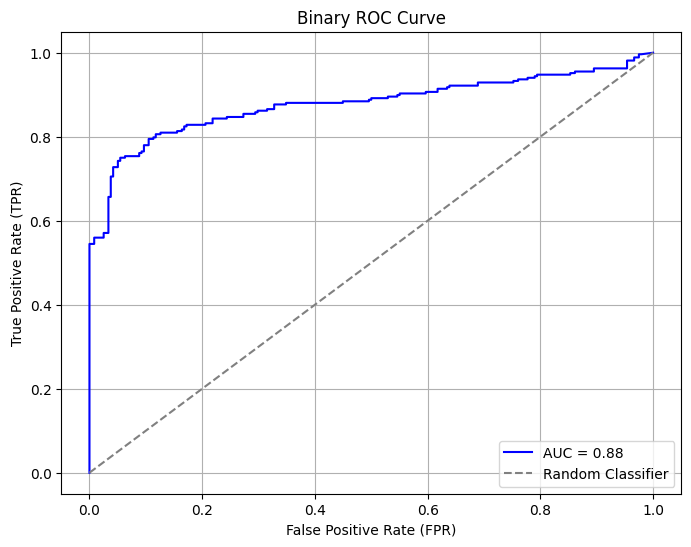

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_probs are already defined
# Get the probabilities for the positive class (class 1: "Unfractured")
positive_class_probs = y_pred_probs[:, 1]  # Extract the probabilities for class 1

# Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, positive_class_probs)

# Calculate AUC (Area Under the Curve)
auc = roc_auc_score(y_true, positive_class_probs)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Classifier")  # Diagonal line
plt.title("Binary ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [20]:
pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


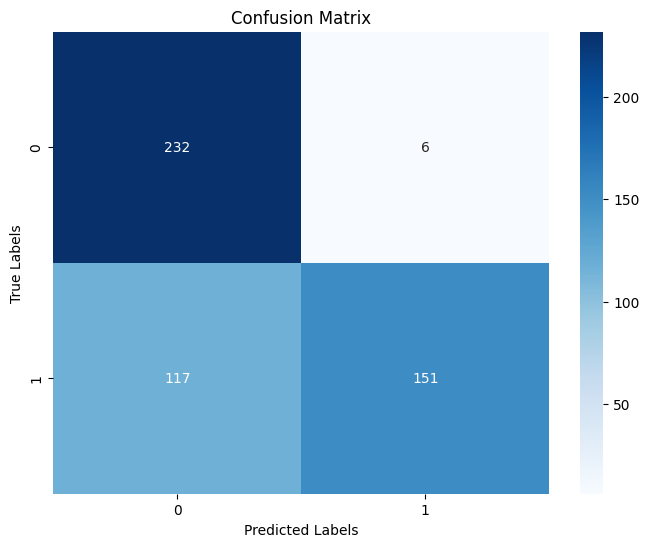

In [21]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [22]:
total_params = model.count_params()
total_params

3304322